## Seq2Seq with Attention

- 参考链接 : https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

- 论文参考链接 : https://arxiv.org/abs/1409.3215

In this project we will be teaching a neural network to translate from French to English.

最终实现的目标如下

```python
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

### 主要思想

An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 数据预处理&读取数据

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    """word → index (word2index) and index → word (index2word) dictionaries
       A count of each word word2count to use to later replace rare words.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
"""
 we will turn Unicode characters to ASCII, make everything lowercase, 
 and trim most punctuation.
"""
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
# 转换为ASCII, 大写变小写, 留下重要的标点, 去掉大部分的标点
normalizeString('I am a Boy!~$%^&')

'i am a boy ! '

In [5]:
def readLangs(lang1, lang2, reverse=False):
    """逐行读取file, 并将每行分为pair, 并做标准化
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

为了加快训练的速度, 我们把句子长度最大设置为10, 同时我们过滤句子后使得其开头变为如i am, he is等词汇

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# 会去掉单词个数超过10个的句子
# 会去掉不是以特定开头的句子
filterPairs([['i am a girl','i am a boy'],
             ['how are you','how are you'],
            ['i am a girl i am a girl i am a girl','i am a girl i am a girl']])

[['i am a girl', 'i am a boy']]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [8]:
def prepareData(lang1, lang2, reverse=False):
    """开始读取语言的文件
    """
    # 读取文件, 返回的是句子对
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # 过滤掉句子对中较长的句子, 和
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
# 开始读取数据
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [10]:
print(random.choice(pairs))

['elles sont mauvaises .', 'they re bad .']


### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [29]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [30]:
# 将一句话中的每个字母转为Index, 并在结尾加上终止符
tensorFromSentence(output_lang, 'i am a boy')

tensor([[  2],
        [ 16],
        [ 42],
        [472],
        [  1]], device='cuda:0')

## The Seq2Seq Model

### Seq2Seq的好处

对比传统的单层的RNN来说, 可以不需要输入和输出是相同的长度的. 

下面是完整的思想, 这里的原文还是很不错的.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size=1, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size # 输入的时候batch_size
        self.n_layers = n_layers # RNN中的层数
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
    def forward(self, x):
        self.sentence_length = x.size(0) # 获取一句话的长度
        embedded = self.embedding(x).view(self.sentence_length, 1, -1) # seq_len * batch_size * word_size
        output = embedded
        self.hidden = self.initHidden()
        output, hidden = self.gru(output, self.hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, self.batch_size, self.hidden_size).to(device)

In [15]:
test_data = tensorsFromPair(random.choice(pairs))
test_data[0]

tensor([[   2],
        [1858],
        [ 253],
        [ 453],
        [ 138],
        [   5],
        [   1]], device='cuda:0')

In [16]:
# encoder测试
encoder1 = EncoderRNN(input_lang.n_words, 256).to(device)
output, hidden = encoder1(test_data[0].unsqueeze(1))

In [17]:
output.shape

torch.Size([7, 1, 256])

In [18]:
hidden.shape

torch.Size([1, 1, 256])

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).
    
### 问题

- decoder下面每次出入的x是什么=>上一次的output
- 如何计算误差

### The Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.(词向量会有整个句子的含义)

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.



In [28]:
class AttenDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttenDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden, encoder_outputs):
        # x是输入, 这里有两种类型
        # hidden是上一层中隐藏层的内容
        # encoder_outputs里面是encoder的RNN的每一步的输出(不是最后一个的输出)
        
        embedded = self.embedding(x).view(1,1,-1)
        embedded = self.dropout(embedded)
        # print('embedded.shape',embedded.shape)
        
        # ----------------------------
        # 下面的attention weight表示:
        # 连接输入的词向量和上一步的hide state并建立bp训练，
        # 他们决定了attention权重
        # -----------------------------
        attn_weights = torch.cat((embedded[0],hidden[0]),1)
        # print('attn_weights1',attn_weights.shape)
        attn_weights = self.attn(attn_weights)
        attn_weights = F.softmax(attn_weights,dim=1)
        # print('attn_weights2',attn_weights.shape)
        
        # 这是做矩阵乘法
        # 施加权重到所有的语义向量上
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # print('attn_applied',attn_applied.shape)
        
        # 加了attention的语义向量和输入的词向量共同作为输
        # 此处对应解码方式三+attention
        output = torch.cat((embedded[0],attn_applied[0]),1)
        # print('output1',output.shape)
        
        # 进入RNN之前，先过了一个全连接层
        output = self.attn_combine(output).unsqueeze(0)
        # print('output2',output.shape)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # print('output3',output.shape)
        
        # 输出分类结果
        output = F.log_softmax(self.out(output[0]),dim=1)
        # print('output4',output.shape)
        return output, hidden, attn_weights

In [21]:
# output是encoder的输出, hidden是encoder的最后的hidden state
output.shape, hidden.shape

(torch.Size([7, 1, 256]), torch.Size([1, 1, 256]))

In [23]:
# 这个是第一个输入, 代表起始符
test_data = torch.tensor([[SOS_token]]).to(device)
test_data

tensor([[0]], device='cuda:0')

In [26]:
# decoder测试
decoder1 = AttenDecoder(256, output_lang.n_words, max_length=output.size(0)).to(device)
output, hidden, attn_weights = decoder1(test_data, hidden, output.squeeze(1))

attn_weights1 torch.Size([1, 512])
attn_weights2 torch.Size([1, 7])
attn_applied torch.Size([1, 1, 256])
output1 torch.Size([1, 512])
output2 torch.Size([1, 1, 256])
output3 torch.Size([1, 1, 256])
output4 torch.Size([1, 2803])


In [39]:
test_output = torch.tensor([[1,2,3],[4,5,6]]).float()
test_outputs = torch.zeros((5,3))
test_outputs[:test_output.size(0)]=test_output
test_outputs

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

## Training

### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.(总体训练流程)



In [32]:
# helper function
import time
import math


def asMinutes(s):
    """将秒转换为分钟
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """打印已经花费的时间和预计花费的时间
       预计花费的时间, 用 完成百分比的时间/现在完成的百分比 来预测
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [44]:
teacher_forcing_ratio = 0.5 # 50%的概率使用teacher_forcing的模式

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)
    # Encoder
    encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
    # 因为一个Decoder的MAX_LENGTH是固定长度的, 所以我们需要将encoder_output变为一样长的
    encoder_output = encoder_output.squeeze(1)
    encoder_outputs = torch.zeros(max_length, encoder_output.size(1)).to(device)
    encoder_outputs[:encoder_output.size(0)] = encoder_output
    
    # Decoder
    loss = 0 
    decoder_hidden = encoder_hidden # encoder最后的hidden作为decoder的hidden
    decoder_input = torch.tensor([[SOS_token]]).to(device)
    # 判断是使用哪一种模式
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss = loss + criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher Forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            loss = loss + criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    # 反向传播, 进行优化
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [41]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    # 初始化优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # 初始化样本
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total = print_loss_total + loss
        plot_loss_total = plot_loss_total + loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Ploting results

In [42]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure(figsize=(14,7))
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Start Training

0m 47s (- 158m 38s) (500 0%) 3.6054
1m 12s (- 119m 27s) (1000 1%) 3.2510
1m 37s (- 106m 31s) (1500 1%) 2.9936
2m 3s (- 100m 28s) (2000 2%) 2.8509
2m 29s (- 97m 11s) (2500 2%) 2.7908
2m 55s (- 94m 27s) (3000 3%) 2.6773
3m 21s (- 92m 44s) (3500 3%) 2.6372
3m 48s (- 91m 15s) (4000 4%) 2.5842
4m 14s (- 90m 11s) (4500 4%) 2.5697
4m 41s (- 89m 3s) (5000 5%) 2.4861
5m 7s (- 88m 5s) (5500 5%) 2.5631
5m 34s (- 87m 14s) (6000 6%) 2.4557
6m 1s (- 86m 34s) (6500 6%) 2.3604
6m 27s (- 85m 43s) (7000 7%) 2.3599
6m 53s (- 84m 56s) (7500 7%) 2.3061
7m 19s (- 84m 13s) (8000 8%) 2.2213
7m 45s (- 83m 34s) (8500 8%) 2.2661
8m 11s (- 82m 54s) (9000 9%) 2.1390
8m 37s (- 82m 11s) (9500 9%) 2.2514
9m 5s (- 81m 47s) (10000 10%) 2.1486
9m 32s (- 81m 20s) (10500 10%) 2.1033
9m 59s (- 80m 47s) (11000 11%) 2.0725
10m 25s (- 80m 10s) (11500 11%) 1.9941
10m 51s (- 79m 38s) (12000 12%) 2.0466
11m 17s (- 79m 4s) (12500 12%) 1.9715
11m 44s (- 78m 37s) (13000 13%) 1.9464
12m 11s (- 78m 6s) (13500 13%) 1.9076
12m 37s (- 7

<Figure size 1008x504 with 0 Axes>

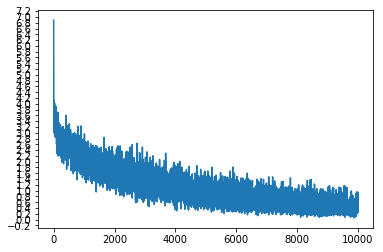

In [54]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = AttenDecoder(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, n_iters=100000, print_every=500, plot_every=10)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [49]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # Encoder
        encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
        encoder_output = encoder_output.squeeze(1)
        encoder_outputs = torch.zeros(max_length, encoder_output.size(1)).to(device)
        encoder_outputs[:encoder_output.size(0)] = encoder_output
        
        
        # Decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length) # 记录输入每个词时的attention weight
        
        for di in range(max_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = attn_weights.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                """遇到终止符就停止
                """
                decoded_words.append('<EOS>')
                break
            else:
                """把decode的word加入数组中
                """
                decoded_words.append(output_lang.index2word[topi.item()])
                
            # 下一个的输入是上一个的输出
            decoder_input = topi.squeeze().detach()

        return decoded_words,decoder_attentions[:di+1]

In [47]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words,_ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [55]:
evaluateRandomly(encoder1, decoder1, n=10)

> je suis membre de ce club de tennis .
= i m in the tennis club .
< i m good tennis in the club . <EOS>

> vous n etes jamais chez vous .
= you re never at home .
< you re never at home . <EOS>

> elle est debutante .
= she is a beginner .
< she is a beginner . <EOS>

> je suis tres heureux de vous rencontrer .
= i m very glad to meet you .
< i m very glad to meet you . <EOS>

> je suis heureux que vous l ayez aime .
= i m happy you liked it .
< i m happy you liked it . <EOS>

> tu ne saignes pas .
= you re not bleeding .
< you re not bleeding . <EOS>

> elle est aimee de ses amies .
= she s loved by her friends .
< she s loved by her friends . <EOS>

> vous faites erreur a ce propos .
= you are mistaken about that .
< you are mistaken about that . <EOS>

> vous vous etes trompe d avion .
= you are on the wrong plane .
< you re on the wrong plane . <EOS>

> nous en avons fini .
= we re finished .
< we re through . <EOS>



## Visualizing Attention

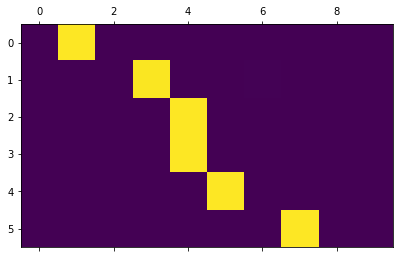

In [56]:
_, attentions = evaluate(encoder1, decoder1, "je suis trop froid .")
plt.matshow(attentions.cpu().numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [52]:
# 更好的可视化
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = c est un jeune directeur plein de talent .
output = he s a talented critic here . <EOS>


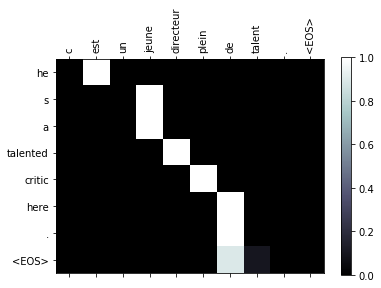

In [57]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")